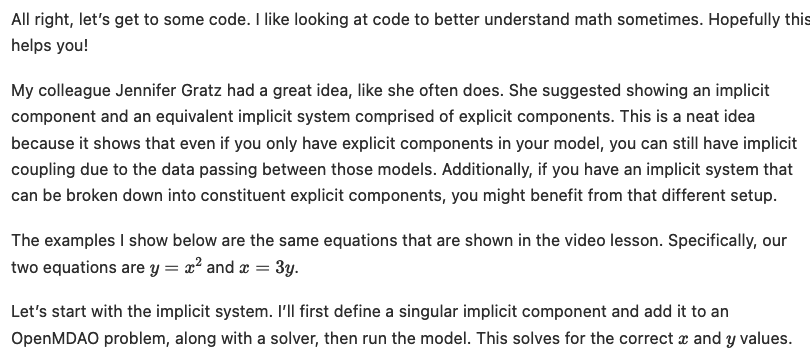

In [4]:
# Implicit System
# This system has a singular implicit component. The ImplicitComponent here is 'class NonlinearEquations'.
# First equation can be defined as y = x**2, and Second equation as x = 3y.

import openmdao.api as om


class NonlinearEquations(om.ImplicitComponent):
    def setup(self):
        self.add_output('x', val=1.0)
        self.add_output('y', val=1.0)
        self.declare_partials('*', '*')

    def apply_nonlinear(self, inputs, outputs, residuals):
        x = outputs['x']
        y = outputs['y']
        residuals['x'] = 3.0*x**2 - x
        # x = 3(x**2) or R(x) = 3(x**2) - x
        residuals['y'] = 9.0*y**2 - y
        # y = (3y)**2 or R(y) = (3y)**2 - y

    def linearize(self, inputs, outputs, jacobian):
        x = outputs['x']
        y = outputs['y']
        jacobian['x', 'x'] = 6.0*x - 1.0
        # First order derivative of R(x)
        jacobian['y', 'y'] = 18.0*y - 1.0
        # First order derivative of R(y)

p = om.Problem()
model = p.model

model.add_subsystem('implicit_component', NonlinearEquations())
model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
# Telling the model to use the newton solver & solve_subsystems=False means that the solver will not solve subsystems.
model.linear_solver = om.DirectSolver()

p.setup()
p.run_model()
p.model.list_outputs()

NL: Newton Converged in 8 iterations
0 Explicit Output(s) in 'model'


2 Implicit Output(s) in 'model'

varname             val         
------------------  ------------
implicit_component
  x                 [0.33333333]
  y                 [0.11111111]




[('implicit_component.x', {'val': array([0.33333333])}),
 ('implicit_component.y', {'val': array([0.11111111])})]

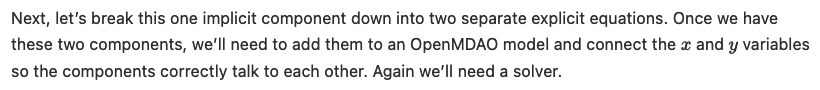

In [6]:
# Splitting one ImplicitComponent into two explicit components

class SquareX(om.ExplicitComponent):
    def setup(self):
        self.add_input('x', val=1.0)
        self.add_output('y', val=1.0)
        self.declare_partials('y', 'x')

    def compute(self, inputs, outputs):
        x = inputs['x']
        outputs['y'] = x**2
        # Computing the First equation of y = x**2.

    def compute_partials(self, inputs, partials):
        partials['y', 'x'] = 2 * inputs['x']
        # Computing the first derivative of the First equation.

class TimesThreeY(om.ExplicitComponent):
    def setup(self):
        self.add_input('y', val=1.0)
        self.add_output('x', val=1.0)
        self.declare_partials('x', 'y', val=3.)

    def compute(self, inputs, outputs):
        y = inputs['y']
        outputs['x'] = 3.0*y
        # Computing the Second equation of x = 3y.
    
    # Why is there no compute_partials method?

p = om.Problem()
model = p.model

model.add_subsystem('square_x', SquareX())
model.add_subsystem('times_three_y', TimesThreeY())

model.connect('square_x.y', 'times_three_y.y')
# Connecting(A.y,B.y), WWhere 'y' variable value from 'ExplicitComponet A' is passed to 'y' variable in 'ExplicitComponent B'.
model.connect('times_three_y.x', 'square_x.x')
# Connecting(A.x,B.x), WWhere 'x' variable value from 'ExplicitComponet B' is passed to 'x' variable in 'ExplicitComponent A'.

model.nonlinear_solver = om.NewtonSolver(solve_subsystems=False)
model.linear_solver = om.DirectSolver()

p.setup()
p.run_model()
p.model.list_outputs()

NL: Newton Converged in 6 iterations
2 Explicit Output(s) in 'model'

varname        val         
-------------  ------------
square_x
  y            [0.11111111]
times_three_y
  x            [0.33333333]


0 Implicit Output(s) in 'model'




[('square_x.y', {'val': array([0.11111111])}),
 ('times_three_y.x', {'val': array([0.33333333])})]

## The above two models show how to write the same problem in two different ways: using 1 ImplicitComponent and using multiple ExplicitComponents in an Implicit System.

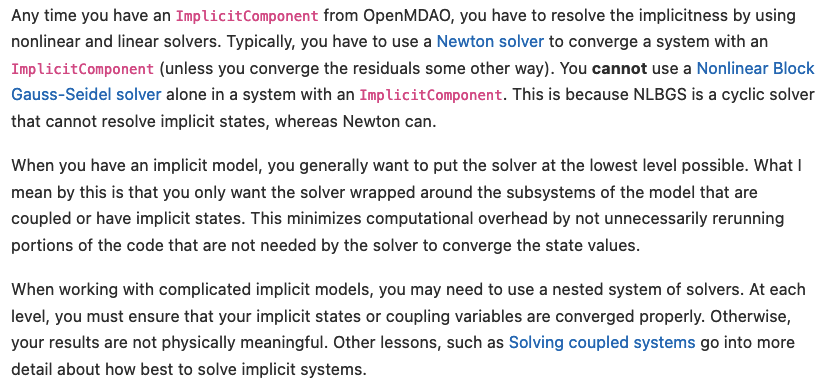